In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import glob
import os
import pandas as pd
import netCDF4
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [ ]:
regrid_files = sorted(glob.glob("/home/alubianashari/RAQMS_Regridded_TEMPO_nc/tracer.202308*.nc"))
print(regrid_files)

In [ ]:
#grouping files by day
daily_files = {}
for f in regrid_files:
    filename = os.path.basename(f)
    timestamp = filename.split('.')[1]
    date_str = timestamp[:8]

    if date_str not in daily_files:
        daily_files[date_str] = [f]
    else:
        daily_files[date_str].append(f)
print(daily_files.keys())

In [ ]:
date = "20230802"
day_files = daily_files[date]

# Load all 4 RAQMS time files
datasets = xr.open_dataset(day_files[0])
lat = datasets['latitude'] 
lon = datasets['longitude']

ds_NO2_00 = np.array(datasets['no2tot'])
datasets = xr.open_dataset(day_files[1])
ds_NO2_06 = np.array(datasets['no2tot'])
datasets = xr.open_dataset(day_files[2])
ds_NO2_12 = np.array(datasets['no2tot'])
datasets = xr.open_dataset(day_files[3])
ds_NO2_18 = np.array(datasets['no2tot'])


ds_NO2 = np.stack([ds_NO2_00, ds_NO2_06, ds_NO2_12, ds_NO2_18], axis=0)
no2_daily_avg = np.nanmean(ds_NO2, axis=0) 

In [ ]:
#check RAQMS shape and range
print(no2_daily_avg.shape)
print(lat.min().values, lat.max().values)
print(lon.min().values, lon.max().values)


In [ ]:
tempo_files = sorted(glob.glob(f"/ships22/raqms/Satellite/TEMPO/V03/L3/NO2/2023/TEMPO_NO2_L3_V03_{date}T*.nc"))

# combined mask 
combined_mask = None
for file in tempo_files:
    try:
        ds_prod = xr.open_dataset(file, group="product")
        ds_supp = xr.open_dataset(file, group="support_data")
        flag = ds_prod['main_data_quality_flag'].squeeze()
        cloud_frac = ds_supp['eff_cloud_fraction'].squeeze()

        mask = (flag != 0) | (cloud_frac >= 0.15)  #  mask where the flag is not zero or cloud fraction is greater than or equal to 0.15

        if combined_mask is None:
            combined_mask = mask
        else:
            combined_mask = combined_mask | mask
    except Exception as e:
        print(f"Skipped {file}: {e}")
        continue

# Convert to numpy
combined_mask = combined_mask.values

# Apply to the daily average
raqms_masked = np.where(combined_mask, np.nan, no2_daily_avg)

In [ ]:
# Apply mask to RAQMS daily average
raqms_masked = np.where(combined_mask, np.nan, no2_daily_avg)

# check shape
print(raqms_masked.shape)


In [ ]:
# === Helper functions ===
def plot_background(ax):
    ax.add_feature(cf.LAKES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.8)
    ax.add_feature(cf.COASTLINE.with_scale('10m'), linewidth=1)
    ax.add_feature(cf.BORDERS.with_scale('10m'), linestyle=':')
    return ax

def plot_ticks(ax, lon_min, lon_max, lat_min, lat_max):
    ax.set_xticks(np.arange(np.floor(lon_min), np.ceil(lon_max)+1, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(np.floor(lat_min), np.ceil(lat_max)+1, 10), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol='°'))
    ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol='°'))
    return ax

# Define lat lon
lon_min, lon_max = lon.min(), lon.max()
lat_min, lat_max = lat.min(), lat.max()


fig, axs = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Unmasked RAQMS
ax = axs[0]
p0 = ax.pcolormesh(lon, lat, no2_daily_avg, cmap="gist_stern_r", vmin=0, vmax=3, transform=ccrs.PlateCarree())
plot_background(ax)
plot_ticks(ax, lon_min, lon_max, lat_min, lat_max)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.set_title("RAQMS NO₂ Daily Avg (Unmasked)")
plt.colorbar(p0, ax=ax, orientation="horizontal", pad=0.05, label='NO₂ (1e16 molecules/cm²)')

# Cloud-masked RAQMS
ax = axs[1]
p1 = ax.pcolormesh(lon, lat, raqms_masked, cmap="gist_stern_r", vmin=0, vmax=3, transform=ccrs.PlateCarree())
plot_background(ax)
plot_ticks(ax, lon_min, lon_max, lat_min, lat_max)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.set_title("RAQMS NO₂ Masked by TEMPO Cloud")
plt.colorbar(p1, ax=ax, orientation='horizontal', pad=0.05, label='NO₂ (1e16 molecules/cm²)')


plt.tight_layout()
plt.show()


In [ ]:
# Paths
raqms_dir = "/home/alubianashari/RAQMS_Regridded_TEMPO_nc/"
tempo_dir = "/ships22/raqms/Satellite/TEMPO/V03/L3/NO2/2023/"
output_dir = "RAQMS_TEMPO_Final_Fig-2"
os.makedirs(output_dir, exist_ok=True)

# Grouping files by day
regrid_files = sorted(glob.glob(f"{raqms_dir}/tracer.202308*.nc"))
daily_files = {}
for f in regrid_files:
    filename = os.path.basename(f)
    date_str = filename.split('.')[1][:8]
    daily_files.setdefault(date_str, []).append(f)

# Process each day
for date, day_files in daily_files.items():

    print(f"Processing {date}...")

    # Load RAQMS and compute daily average
    no2_stack = np.stack([
        xr.open_dataset(day_files[0])["no2tot"].values,
        xr.open_dataset(day_files[1])["no2tot"].values,
        xr.open_dataset(day_files[2])["no2tot"].values,
        xr.open_dataset(day_files[3])["no2tot"].values,
    ], axis=0)
    no2_daily_avg = np.nanmean(no2_stack, axis=0)

    ds = xr.open_dataset(day_files[0])
    lat = ds["latitude"].values
    lon = ds["longitude"].values

    # Load TEMPO files for this date
    tempo_files = sorted(glob.glob(f"{tempo_dir}/TEMPO_NO2_L3_V03_{date}T*.nc"))
    if not tempo_files:
        print(f"  No TEMPO files found for {date}, skipping.")
        continue

    # Build combined mask
    # Initialize combined_mask as True (False where any scan is good; flag=0 cloud_frac < 0.15)
    combined_mask = np.full_like(no2_daily_avg, True, dtype=bool)

    for file in tempo_files:
        try:
            ds_prod = xr.open_dataset(file, group="product")
            ds_supp = xr.open_dataset(file, group="support_data")

            flag = ds_prod['main_data_quality_flag'].squeeze()
            cloud_frac = ds_supp['eff_cloud_fraction'].squeeze()
            good_mask = (flag == 0) & (cloud_frac < 0.15)
            valid_obs = np.isfinite(flag)

            # Unmask RAQMS if this pixel is good
            combined_mask = np.where(valid_obs & good_mask, False, combined_mask)

        except Exception as e:
            print(f"  Skipped {file}: {e}")
            continue

    # Apply mask to RAQMS
    raqms_masked = np.where(combined_mask, np.nan, no2_daily_avg)

    # Plotting
    fig = plt.figure(figsize=(10, 6), dpi=150)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-145, -35, 15, 65], crs=ccrs.PlateCarree())

    ax.add_feature(cf.LAKES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.8)
    ax.add_feature(cf.COASTLINE.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=1)
    ax.add_feature(cf.BORDERS.with_scale('10m'), linestyle=':')
    ax.add_feature(cf.STATES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.4)

    ax.set_xticks(np.arange(-140, -30 + 1, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(20, 60 + 1, 10), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(number_format='.0f', degree_symbol='°'))
    ax.yaxis.set_major_formatter(LatitudeFormatter(number_format='.0f', degree_symbol='°'))

    mesh = ax.pcolormesh(lon, lat, raqms_masked, transform=ccrs.PlateCarree(),
                         cmap='gist_stern_r', vmin=0, vmax=3, shading='auto')

    plt.colorbar(mesh, orientation='horizontal',
                 label='RAQMS Total Column NO₂ (10¹⁶ molecules/cm²)', fraction=0.046, pad=0.1)

    title_date = f"{date[:4]}-{date[4:6]}-{date[6:]}"
    ax.set_title(f"RAQMS Total Column NO₂ (Cloud-Masked by TEMPO) – {title_date}")

    plt.tight_layout()
    plt.savefig(f"{output_dir}/RAQMS_CloudMasked_{date}.png", facecolor='white', bbox_inches='tight')
    plt.close()


NameError: name 'plot_output_dir' is not defined

In [13]:
# Paths
raqms_dir = "/home/alubianashari/RAQMS_Regridded_TEMPO_nc/"
tempo_dir = "/ships22/raqms/Satellite/TEMPO/V03/L3/NO2/2023/"
output_dir = "RAQMS_TEMPO_Final_Fig-2n"
save_dir = "/home/alubianashari/RAQMS_CloudMasked_TEMPO/"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(save_dir, exist_ok=True)

# Group RAQMS files by date
regrid_files = sorted(glob.glob(f"{raqms_dir}/tracer.202308*.nc"))
daily_files = {}
for f in regrid_files:
    filename = os.path.basename(f)
    date_str = filename.split('.')[1][:8]
    daily_files.setdefault(date_str, []).append(f)

# Process each day
for date, day_files in daily_files.items():
    print(f"\nProcessing {date}...")

    # Load RAQMS and compute daily average
    no2_stack = np.stack([
        xr.open_dataset(day_files[0])["no2tot"].values,
        xr.open_dataset(day_files[1])["no2tot"].values,
        xr.open_dataset(day_files[2])["no2tot"].values,
        xr.open_dataset(day_files[3])["no2tot"].values,
    ], axis=0)
    no2_daily_avg = np.nanmean(no2_stack, axis=0)

   
    ds = xr.open_dataset(day_files[0])
    lat = ds["latitude"].values
    lon = ds["longitude"].values

    # Load TEMPO files
    tempo_files = sorted(glob.glob(f"{tempo_dir}/TEMPO_NO2_L3_V03_{date}T*.nc"))
    if not tempo_files:
        print(f"  No TEMPO files found for {date}, skipping.")
        continue

    # Build RAQMS mask and compute TEMPO daily average
    combined_mask = np.full_like(no2_daily_avg, True, dtype=bool)
    tempo_sum = None
    tempo_count = None

    for file in tempo_files:
        try:
            ds_prod = xr.open_dataset(file, group="product")
            ds_supp = xr.open_dataset(file, group="support_data")

            flag = ds_prod['main_data_quality_flag'].squeeze()
            cloud = ds_supp['eff_cloud_fraction'].squeeze()
            no2 = (ds_prod['vertical_column_troposphere'] + ds_prod['vertical_column_stratosphere']).squeeze() / 1e16

            valid = (flag == 0) & (cloud < 0.15)

            combined_mask = np.where(np.isfinite(flag) & valid, False, combined_mask)

            # TEMPO daily average
            if tempo_sum is None:
                tempo_sum = no2.where(valid).fillna(0)
                tempo_count = valid.astype(int)
            else:
                tempo_sum += no2.where(valid).fillna(0)
                tempo_count += valid.astype(int)

        except Exception as e:
            print(f"  Skipped {file}: {e}")
            continue


    raqms_masked = np.where(combined_mask, np.nan, no2_daily_avg)
    tempo_avg = (tempo_sum / tempo_count).where(tempo_count > 0).squeeze()

    # Plot 
    fig = plt.figure(figsize=(10, 6), dpi=150)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-145, -35, 15, 65], crs=ccrs.PlateCarree())

    ax.add_feature(cf.LAKES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.8)
    ax.add_feature(cf.COASTLINE.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=1)
    ax.add_feature(cf.BORDERS.with_scale('10m'), linestyle=':')
    ax.add_feature(cf.STATES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.4)

    ax.set_xticks(np.arange(-140, -30 + 1, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(20, 60 + 1, 10), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(number_format='.0f', degree_symbol='°'))
    ax.yaxis.set_major_formatter(LatitudeFormatter(number_format='.0f', degree_symbol='°'))

    mesh = ax.pcolormesh(lon, lat, raqms_masked, transform=ccrs.PlateCarree(),
                         cmap='gist_stern_r', vmin=0, vmax=3, shading='auto')
    plt.colorbar(mesh, orientation='horizontal',
                 label='RAQMS Total Column NO₂ (10¹⁶ molecules/cm²)', fraction=0.046, pad=0.1)

    ax.set_title(f"RAQMS Total Column NO₂ (Cloud-Masked by TEMPO) – {date[:4]}-{date[4:6]}-{date[6:]}")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/RAQMS_CloudMasked_{date}.png", facecolor='white', bbox_inches='tight')
    plt.close()

    # Save to nc
    xr.Dataset(
        {
            "no2_daily_avg": (["lat", "lon"], no2_daily_avg),
            "no2_masked": (["lat", "lon"], raqms_masked),
            "tempo_no2_avg": (["lat", "lon"], tempo_avg.data),
        },
        coords={"lat": lat, "lon": lon}
    ).to_netcdf(f"{save_dir}/RAQMS_TEMPO_{date}.nc")

    print(f"Saved NetCDF for {date}")



Processing 20230801...
  No TEMPO files found for 20230801, skipping.

Processing 20230802...
Saved NetCDF for 20230802

Processing 20230803...
  No TEMPO files found for 20230803, skipping.

Processing 20230804...
Saved NetCDF for 20230804

Processing 20230805...
Saved NetCDF for 20230805

Processing 20230806...
Saved NetCDF for 20230806

Processing 20230807...
Saved NetCDF for 20230807

Processing 20230808...
Saved NetCDF for 20230808

Processing 20230809...
Saved NetCDF for 20230809

Processing 20230810...
  No TEMPO files found for 20230810, skipping.

Processing 20230811...
Saved NetCDF for 20230811

Processing 20230812...
Saved NetCDF for 20230812

Processing 20230813...
  No TEMPO files found for 20230813, skipping.

Processing 20230814...
  No TEMPO files found for 20230814, skipping.

Processing 20230815...
Saved NetCDF for 20230815

Processing 20230816...
Saved NetCDF for 20230816

Processing 20230817...
Saved NetCDF for 20230817

Processing 20230818...
Saved NetCDF for 2023

In [ ]:

# check the output
file_path = "/home/alubianashari/RAQMS_CloudMasked_TEMPO/RAQMS_TEMPO_20230815.nc"

# Open the dataset
ds = xr.open_dataset(file_path)

# Print summary
print(ds)


<xarray.Dataset> Size: 366MB
Dimensions:        (lat: 2950, lon: 7750)
Coordinates:
  * lat            (lat) float32 12kB 14.01 14.03 14.05 ... 72.95 72.97 72.99
  * lon            (lon) float32 31kB -168.0 -168.0 -167.9 ... -13.03 -13.01
Data variables:
    no2_daily_avg  (lat, lon) float32 91MB ...
    no2_masked     (lat, lon) float32 91MB ...
    tempo_no2_avg  (lat, lon) float64 183MB ...


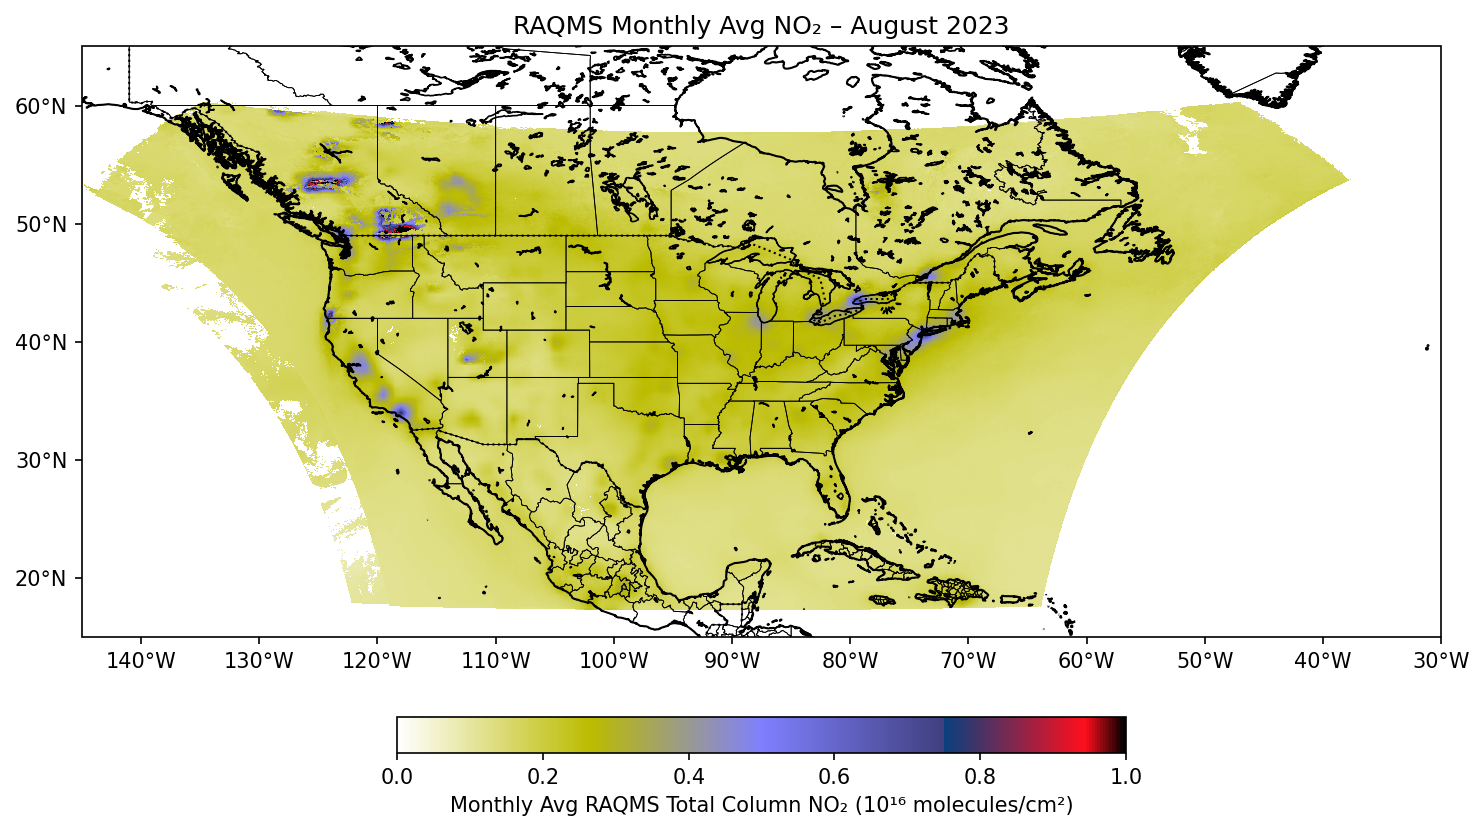

Included dates:
RAQMS_TEMPO_20230802.nc
RAQMS_TEMPO_20230804.nc
RAQMS_TEMPO_20230805.nc
RAQMS_TEMPO_20230806.nc
RAQMS_TEMPO_20230807.nc
RAQMS_TEMPO_20230808.nc
RAQMS_TEMPO_20230809.nc
RAQMS_TEMPO_20230811.nc
RAQMS_TEMPO_20230812.nc
RAQMS_TEMPO_20230815.nc
RAQMS_TEMPO_20230816.nc
RAQMS_TEMPO_20230817.nc
RAQMS_TEMPO_20230818.nc
RAQMS_TEMPO_20230819.nc
RAQMS_TEMPO_20230820.nc
RAQMS_TEMPO_20230821.nc
RAQMS_TEMPO_20230822.nc
RAQMS_TEMPO_20230825.nc
RAQMS_TEMPO_20230826.nc
RAQMS_TEMPO_20230828.nc
RAQMS_TEMPO_20230829.nc
RAQMS_TEMPO_20230830.nc
RAQMS_TEMPO_20230831.nc


In [2]:
# RAQMS Monthly Average Plot, excluding specific dates
# Load files
data_dir = "/home/alubianashari/RAQMS_CloudMasked_TEMPO/"
exclude_dates = ["20230823", "20230827"]
files = sorted(glob.glob(os.path.join(data_dir, "RAQMS_TEMPO_202308*.nc")))
files = [f for f in files if not any(date in f for date in exclude_dates)]

# Open and stack daily data
data_list = []
for f in files:
    ds = xr.open_dataset(f)
    data_list.append(ds["no2_masked"])

stacked = xr.concat(data_list, dim="time")

# Compute monthly mean
monthly_avg = stacked.mean(dim="time", skipna=True)
lat = ds["lat"]
lon = ds["lon"]

# Plotting
fig = plt.figure(figsize=(10, 6), dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-145, -35, 15, 65], crs=ccrs.PlateCarree())

ax.add_feature(cf.LAKES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.8)
ax.add_feature(cf.COASTLINE.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=1)
ax.add_feature(cf.BORDERS.with_scale('10m'), linestyle=':')
ax.add_feature(cf.STATES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.4)

ax.set_xticks(np.arange(-140, -30 + 1, 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(20, 60 + 1, 10), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(number_format='.0f', degree_symbol='°'))
ax.yaxis.set_major_formatter(LatitudeFormatter(number_format='.0f', degree_symbol='°'))

mesh = ax.pcolormesh(lon, lat, monthly_avg, transform=ccrs.PlateCarree(),
                     cmap='gist_stern_r', vmin=0, vmax=1, shading='auto')
plt.colorbar(mesh, orientation='horizontal',
             label='Monthly Avg RAQMS Total Column NO₂ (10¹⁶ molecules/cm²)',
             fraction=0.046, pad=0.1)

ax.set_title("RAQMS Monthly Avg NO₂ – August 2023")
plt.tight_layout()
plt.savefig("monthly_avg_TEMPO/RAQMS_MonthlyAvg_Aug2023_v2_2.png", facecolor='white', bbox_inches='tight')
plt.show()

print("Included dates:")
for f in files:
    print(os.path.basename(f))

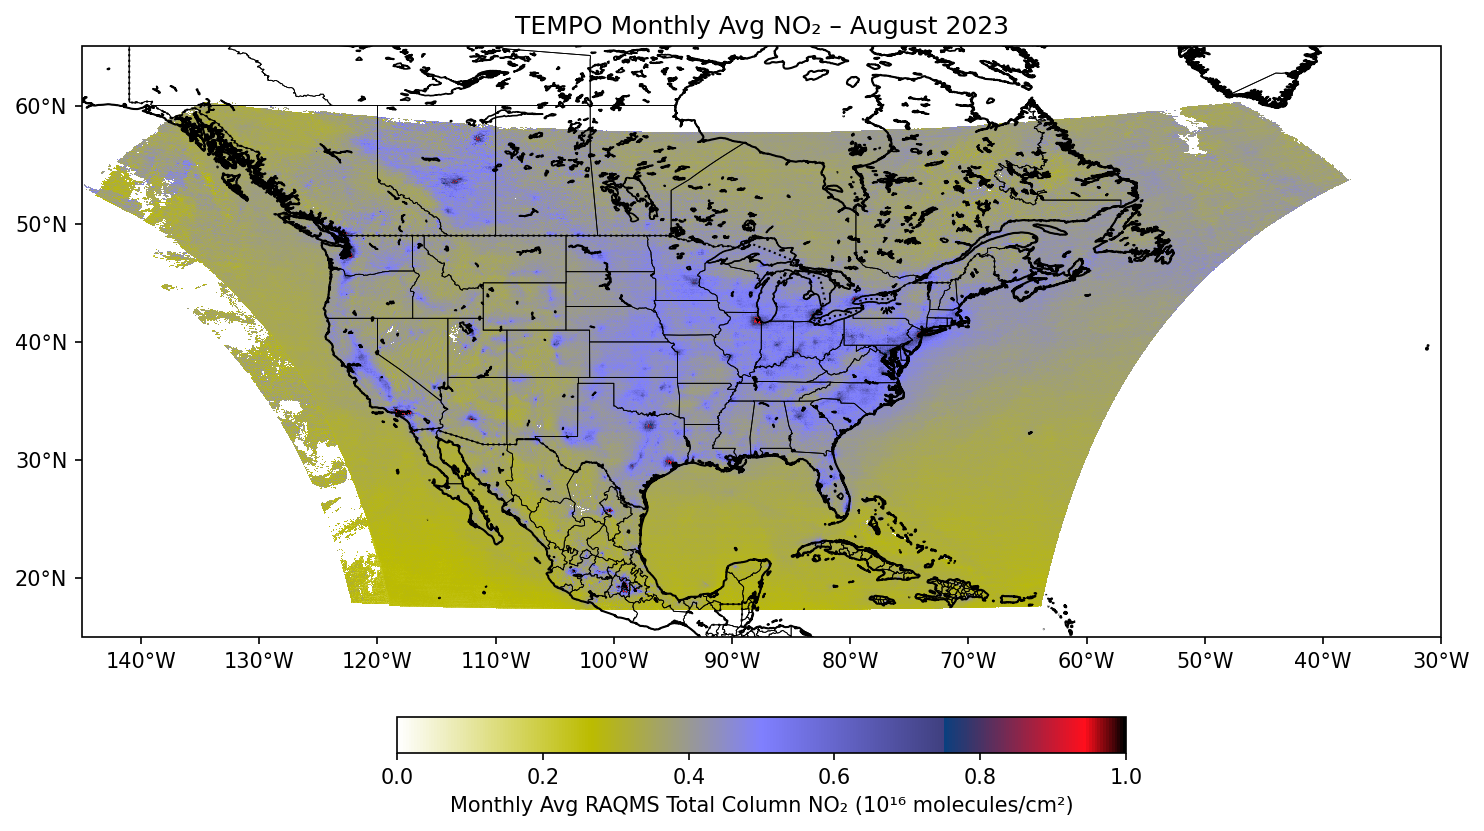

In [3]:
# TEMPO Monthly Average Plot
# Load files
data_dir = "/home/alubianashari/RAQMS_CloudMasked_TEMPO/"
files = sorted(glob.glob(os.path.join(data_dir, "RAQMS_TEMPO_202308*.nc")))
exclude_dates = ["20230823", "20230827"]
files = [f for f in files if not any(date in f for date in exclude_dates)]

# Open and stack daily data
data_list = []
for f in files:
    ds = xr.open_dataset(f)
    data_list.append(ds["tempo_no2_avg"])

stacked = xr.concat(data_list, dim="time")

# Compute monthly mean
monthly_avg = stacked.mean(dim="time", skipna=True)
lat = ds["lat"]
lon = ds["lon"]

# Plotting
fig = plt.figure(figsize=(10, 6), dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-145, -35, 15, 65], crs=ccrs.PlateCarree())

ax.add_feature(cf.LAKES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.8)
ax.add_feature(cf.COASTLINE.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=1)
ax.add_feature(cf.BORDERS.with_scale('10m'), linestyle=':')
ax.add_feature(cf.STATES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.4)

ax.set_xticks(np.arange(-140, -30 + 1, 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(20, 60 + 1, 10), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(number_format='.0f', degree_symbol='°'))
ax.yaxis.set_major_formatter(LatitudeFormatter(number_format='.0f', degree_symbol='°'))

mesh = ax.pcolormesh(lon, lat, monthly_avg, transform=ccrs.PlateCarree(),
                     cmap='gist_stern_r', vmin=0, vmax=1, shading='auto')
plt.colorbar(mesh, orientation='horizontal',
             label='Monthly Avg RAQMS Total Column NO₂ (10¹⁶ molecules/cm²)',
             fraction=0.046, pad=0.1)

ax.set_title("TEMPO Monthly Avg NO₂ – August 2023")
plt.tight_layout()
plt.savefig("monthly_avg_TEMPO/TEMPO_MonthlyAvg_Aug2023_v2_2.png", facecolor='white', bbox_inches='tight')
plt.show()